# LARS

LARS is an efficient method for calculating sparse Lasso coefficients.  It determines them piece-wise, rather than needing an incremental approach (cf stagewise), or taking potentially overly large steps (cf forward selection).  LARS itself gives a slightly different solution than Lasso, but can be modified very slightly to give the Lasso solution.

## Lasso

Lasso gives a sparse solution to a regression problem.  It can be viewed either as a solution to the constrained problem, where `sum(abs(coefficients)) <= k`, or as a solution to the regularized loss, via the Lagrangian dual, with L1 regularization `C * sum(abs(coefficients))`.  For any value of `k`, a value of `C` can be found which gives an equivalent solution, and visa versa.

## Algorithm

In LARS, we consider the dataset as a set of vectors, one per feature.  For example, in the diabetes dataset, with 10 features, we have 10 vectors, each of length 442.  So, each axis in the vector represents one data point.   We normalize each vector to unit length.

toy.X [[-0.54790151  1.29491463]
 [ 0.49433234  0.5767346 ]]
y [1 0]
variate lengths [ 0.73794344  1.41754248]
variate lengths [ 1.  1.]
toy.X [[-0.74247087  0.91349264]
 [ 0.66987835  0.40685525]]
toy.X [[-0.74247087  0.91349264]
 [ 0.66987835  0.40685525]]
variate lengths [ 1.  1.]
variate lengths [ 1.  1.]
toy.X [[-0.74247087  0.91349264]
 [ 0.66987835  0.40685525]]
cos_theta [-0.74247087  0.91349264]
angle [ 137.94200107   24.0073829 ]


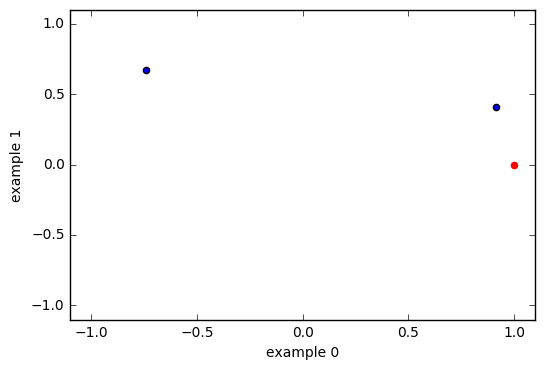

In [105]:
## import matplotlib.pyplot as plt
import numpy as np


# Lets imagine a dataset with 2 features, and 2 data points

# Not normalizing mean to 0 for now, otherwise we just can have two different covariant vectors, ie
# (sqrt(2), -sqrt(2)), and (-sqrt(2), sqrt(2))

class ToyData(object):
    def __init__(self):
        pass

toy = ToyData()
toy.m = 2
toy.n = 2
toy.rand = np.random.mtrand.RandomState(132)
toy.X = toy.rand.randn(toy.n, toy.m)
  
print('toy.X', toy.X)
toy.rand = np.random.mtrand.RandomState(122)
toy.y = toy.rand.randint(0, 2, size=(toy.n,))
print('y', toy.y)
print('variate lengths', np.sqrt(np.sum(toy.X * toy.X, 0)))
toy.X /= np.sqrt(np.sum(toy.X * toy.X, 0))
print('variate lengths', np.sqrt(np.sum(toy.X * toy.X, 0)))
print('toy.X', toy.X)
#     toy.X -= np.average(toy.X, 0)
print('toy.X', toy.X)
print('variate lengths', np.sqrt(np.sum(toy.X * toy.X, 0)))
toy.X /= np.sqrt(np.sum(toy.X * toy.X, 0))
print('variate lengths', np.sqrt(np.sum(toy.X * toy.X, 0)))
print('toy.X', toy.X)

toy.residual = toy.y
toy.cos_theta = toy.X.T.dot(toy.residual)
toy.angle = np.arccos(toy.cos_theta) * 180 / 3.1416
print('cos_theta', toy.cos_theta)
print('angle', toy.angle)

plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')
plt.scatter(toy.X[0], toy.X[1])
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.show()

# toy_stepone()

We can see that covariate j=1, having angle 24.0 degrees, will get us closer to y fastest.  So, we will walk along that first.  Note that we can walk along the covariates in either direction, so we actually have a few more possibilities.  In the next plot, blue points are covariates in the positive direction, and green are the same covariates, in the negative direction.

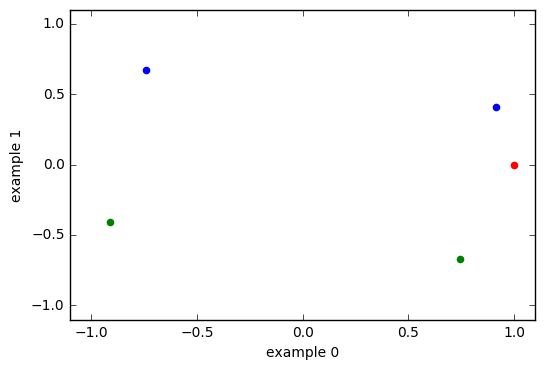

angle [ 137.94200107   24.0073829 ]
angle [  42.05799893  155.9926171 ]


In [106]:
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')
plt.scatter(toy.X[0], toy.X[1], color='blue')
plt.scatter(-toy.X[0], -toy.X[1], color='green')
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.show()

print('angle', toy.angle)
print('angle', 180 - toy.angle)


So, covariate j=0, in the reverse direction could make progress towards the residual too, but not quite as fast.  So we will start walking along covariate j=1, in the positive direction.

As we walk along j=1, the residual will gradually rotate, clockwise.  At some point, the j=0 covariate, in the reverse direction, will have an angle that will move in the residual direction faster.

So, there will be two directions we will walk along:
    - covariate j=1, positive direction, and then, per the LARS algorithm:
    - a vector midway between covariate j=1, in positive direction, and covariate j=0, in negative direction
    
In the following plot:
- blue vector is covariate j=1
- green vector is negative covariate j=0
- purple vector is equi-angular between the two

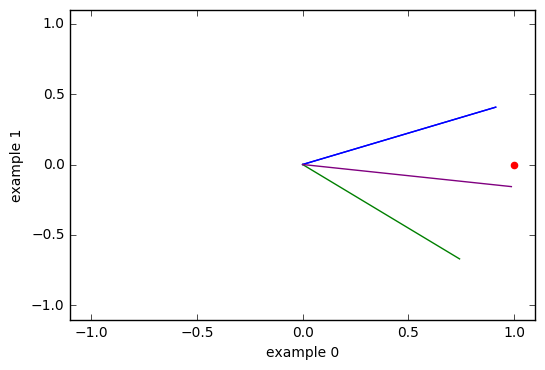

In [111]:
toy.walk0 = toy.X[:, 1]
toy.walk1 = toy.X[:, 1] - toy.X[:, 0]
# normalize length to 1:
toy.walk1 /= np.sqrt(np.sum(toy.walk1 * toy.walk1))

plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')
plt.plot((0, toy.walk0[0]), (0, toy.walk0[1]), color='blue')
plt.plot((0, - toy.X[0, 0]), (0, -toy.X[1, 0]), color='green')
plt.plot((0, toy.walk1[0]), (0, toy.walk1[1]), color='purple')
# plt.scatter(-toy.X[0], -toy.X[1], color='green')
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.show()

Next, the result should be the residual (in this case, with 2 examples, and 2 features, since we get an exact solution), so we have:

```
a_0 * walk0 + a_1 * walk1 = y
```
Out of this, we know `walk0`, `walk1`, `y`.  `a_0` and `a_1` are scalars.  `walk0` and `walk1` are 2-dimensional vectors, so this is two equations, in two unknowns.  Solution is:

In [115]:
import numpy as np

toy.sa = np.zeros((2, 2), dtype=np.float32)
toy.sa[:, 0] = toy.walk0
toy.sa[:, 1] = toy.walk1
toy.sb = toy.y
toy.sx = np.linalg.solve(toy.sa, toy.sb)

print(toy.sx)

[ 0.28776921  0.74636522]


check:

In [116]:
print(toy.sx[0] * toy.walk0 + toy.sx[1] * toy.walk1)

[  1.00000003e+00   1.30687267e-09]


It equals `y`, as required.

So, this looks like:

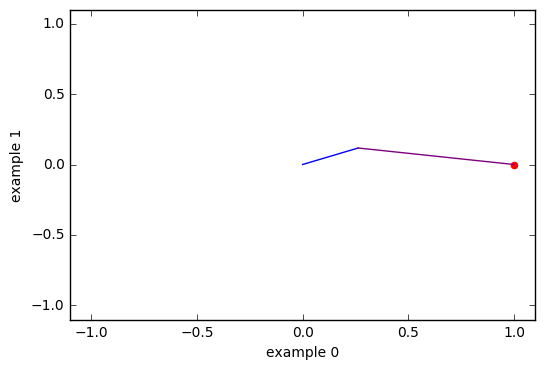

In [123]:
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)
plt.xlabel('example 0')
plt.ylabel('example 1')

toy.p0 = np.zeros((2,))
toy.p1 = toy.p0 + toy.sx[0] * toy.walk0
toy.p2 = toy.p1 + toy.sx[1] * toy.walk1

plt.plot((toy.p0[0], toy.p1[0]), (toy.p0[1], toy.p1[1]), color='blue')
plt.plot((toy.p1[0], toy.p2[0]), (toy.p1[1], toy.p2[1]), color='purple')
plt.scatter(toy.y[0], toy.y[1], color='red')
plt.show()

Note that the actual LARS calculates the `gamma` values, ie the step sizes, in closed form, without needing to call out to a solver.

## Diabetes dataset

In [125]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt


diabetes_train_splitsize = 1.0

beta_path = None
sum_abs_coeff = None


def fetch_diabetes(subset='train'):
    diabetes = sklearn.datasets.load_diabetes()
    X_all = diabetes.data
    y_all = diabetes.target

    total_N = len(y_all)
    train_N = int(total_N * diabetes_train_splitsize)
    test_N = total_N - train_N
    rand = np.random.mtrand.RandomState(seed=123)
    train_idx = set(rand.choice(total_N, size=(train_N,), replace=False))

    train_X = X_all[list(train_idx)]
    train_y = y_all[list(train_idx)]

    test_idx = np.zeros((test_N,), dtype=np.int32)
    test_n = 0
    for n in range(total_N):
        if n not in train_idx:
            test_idx[test_n] = n
            test_n += 1
    test_X = X_all[test_idx]
    test_y = y_all[test_idx]

    def get_add_mul(X):
        add = - np.average(X, 0)
        X1 = X + add
        mul = 1 / np.sqrt((X1 * X1).sum(0))
        return add, mul

    X_add, X_mul = get_add_mul(train_X)
    y_add = - np.average(train_y)

    train_X = (train_X + X_add) * X_mul
    train_y = train_y + y_add
    if len(test_X) > 0:
        test_X = (test_X + X_add) * X_mul
        test_y = test_y + y_add

    if subset == 'train':
        return sklearn.datasets.base.Bunch(data=train_X, target=train_y)
    elif subset == 'test':
        return sklearn.datasets.base.Bunch(data=test_X, target=test_y)
    else:
        raise Exception('unknown subset %s' % subset)


def vector_len(vector):
    return np.sqrt(np.sum(vector * vector))


def run_lars(train):
    global beta_path, sum_abs_coeff

    X = train.data
    y = train.target
    m = len(X[0])
    n = len(X)

    active_set = set()
    cur_pred = np.zeros((n,), dtype=np.float32)
    residual = y - cur_pred
    cur_corr = X.transpose().dot(residual)
    j = np.argmax(np.abs(cur_corr), 0)
    print('j', j)
    active_set.add(j)
    beta = np.zeros((m,), dtype=np.float32)
    sign = np.zeros((m,), dtype=np.int32)
    sign[j] = 1

    beta_path = np.zeros((m, m), dtype=np.float32)
    for it in range(m):
        residual = y - cur_pred
        mse = np.sqrt(np.sum(residual * residual))
        print('mse', mse)

        pred_from_beta = X.dot(beta)

        cur_corr = X.transpose().dot(residual)

        X_a = X[:, list(active_set)]
        X_a *= sign[list(active_set)]
        G_a = X_a.transpose().dot(X_a)
        G_a_inv = np.linalg.inv(G_a)
        G_a_inv_red_cols = np.sum(G_a_inv, 1)
        A_a = 1 / np.sqrt(np.sum(G_a_inv_red_cols))
        omega = A_a * G_a_inv_red_cols
        equiangular = X_a.dot(omega)  # .reshape(n)

        cos_angle = X.transpose().dot(equiangular)
        gamma = None
        largest_abs_correlation = np.abs(cur_corr).max()
        print('largest_abs_correlation', largest_abs_correlation)
        if it < m - 1:
            next_j = None
            next_sign = 0
            for j in range(m):
                if j in active_set:
                    continue
                v0 = (largest_abs_correlation - cur_corr[j]) / (A_a - cos_angle[j]).item()
                v1 = (largest_abs_correlation + cur_corr[j]) / (A_a + cos_angle[j]).item()
                if v0 > 0 and (gamma is None or v0 < gamma):
                    next_j = j
                    gamma = v0
                    next_sign = 1
                if v1 > 0 and (gamma is None or v1 < gamma):
                    gamma = v1
                    next_j = j
                    next_sign = -1
        else:
            gamma = largest_abs_correlation / A_a

        # coeffs, eg for 3 vectors
        #
        # I reckon there should be a faster (ie closed-form) way of doing this, but this way works for now:
        #
        # c_0 * x_0 + c_1 * x_1 + c_2 * x_2 = equiangular
        # we know: x_0, x_1, x_2, equiangular
        # they're all vectors, so equation must hold for each dimension
        # ie, we have equations:
        # c_0 * x_0_0 + c_1 * x_1_0 + c_2 * x_2_0 = equi_0
        # c_0 * x_0_1 + c_1 * x_1_1 + c_2 * x_2_1 = equi_1
        # c_0 * x_0_2 + c_1 * x_1_2 + c_2 * x_2_2 = equi_2
        # ...
        # comparing with doc at
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.solve.html#numpy.linalg.solve
        # their x_0, x_1, x_2 is our c_0, c_1, c_2
        # their constants are our x_0_0, ...
        # edit since not square, trying
        # https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html#numpy.linalg.lstsq
        sa = X_a
        sb = equiangular * gamma
        sx = np.linalg.lstsq(sa, sb)
        for i, j in enumerate(active_set):
            beta[j] += sx[0][i] * sign[j]

        print('next j', next_j, 'next sign', next_sign, 'gamma', gamma, 'new max correlation: %s' % (
            largest_abs_correlation - gamma * A_a))

        cur_pred = X.dot(beta)
        active_set.add(next_j)
        sign[next_j] = next_sign

        beta_path[it, :] = beta
        print('beta', beta)

    print('beta_path', beta_path)
    sum_abs_coeff = np.sum(np.abs(beta_path), 1)
    print('sum_abs_coeff', sum_abs_coeff)
    

def run():
    train = fetch_diabetes(subset='train')
    test = fetch_diabetes(subset='test')
    print((train.data * train.data).sum(0))
    print((test.data * test.data).sum(0))
    print(np.average(train.target, 0))
    print(np.average(test.target, 0))
    run_lars(train)


run()

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
-7.71630120282e-15
nan
j 2
mse 1618.95309519
largest_abs_correlation 949.435260384
next j 8 next sign 1 gamma 60.1192696491 new max correlation: 889.315990735
beta [  0.           0.          60.11927032   0.           0.           0.           0.
   0.           0.           0.        ]
mse 1584.44461593
largest_abs_correlation 889.315990434
next j 3 next sign 1 gamma 513.223718805 new max correlation: 452.900968682
beta [   0.            0.          361.8946228     0.            0.            0.
    0.            0.          301.77532959    0.        ]
mse 1303.98189348
largest_abs_correlation 452.900977508
next j 6 next sign -1 gamma 175.553241509 new max correlation: 316.074046695
beta [   0.            0.          434.75796509   79.23645782    0.            0.
    0.            0.          374.91583252    0.        ]
mse 1235.78501888
largest_abs_correlation 316.074050463
next j 1 next sign -1 gamm

/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/ubuntu/.local/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


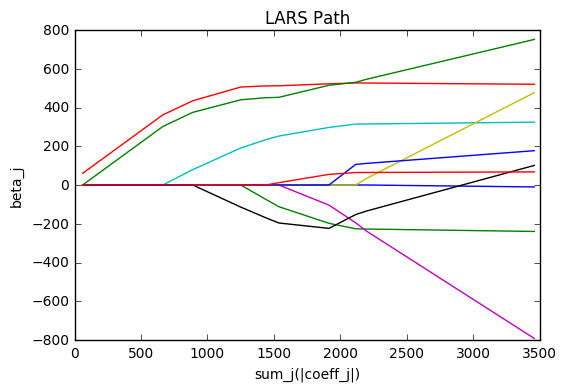

In [10]:
# plotting code is based on:
# http://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_lars.html
plt.plot(sum_abs_coeff, beta_path)
plt.title('LARS Path')
plt.ylabel('beta_j')
plt.xlabel('sum_j(|coeff_j|)')
plt.show()
